In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")
sns.set_palette("rocket")
# sns.set_palette("mako")

pi = np.pi

# FBM

In [18]:
def autocovariance(k, H):
        return 0.5 * (abs(k - 1) ** (2 * H) - 2 * abs(k) ** (2 * H) + abs(k + 1) ** (2 * H))

def cholesky_fbm(T, n, H, trajectories = 1, G = None, C = None):
    scale = (T /n) ** H
    if not G:
        G = np.zeros([n, n])
        for i in range(n):
            for j in range(i + 1):
                G[i, j] = autocovariance(i - j, H)
    if not C:
        C = np.linalg.cholesky(G)
    gn = np.random.normal(0.0, 1.0, (trajectories, n))
    fgn = np.dot(C, gn.T) * scale
    return np.insert(np.cumsum(fgn, 0)[:-1], 0, 0, axis=0)

def get_quantils(df, quantiles, ts):
    N = df.shape[0]
    qs = np.zeros((N, len(quantiles)))
    for i, row in df.iterrows():
        qs[i]= [np.quantile(row, q) for q in quantiles] 
    quantiles_Df = pd.DataFrame(qs.T, columns = ts)
    quantiles_Df["rang"] = quantiles
    return quantiles_Df


## (a) sample trajectories

In [37]:
T = 1
n = 2000
H = 0.5
t_s = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 50)

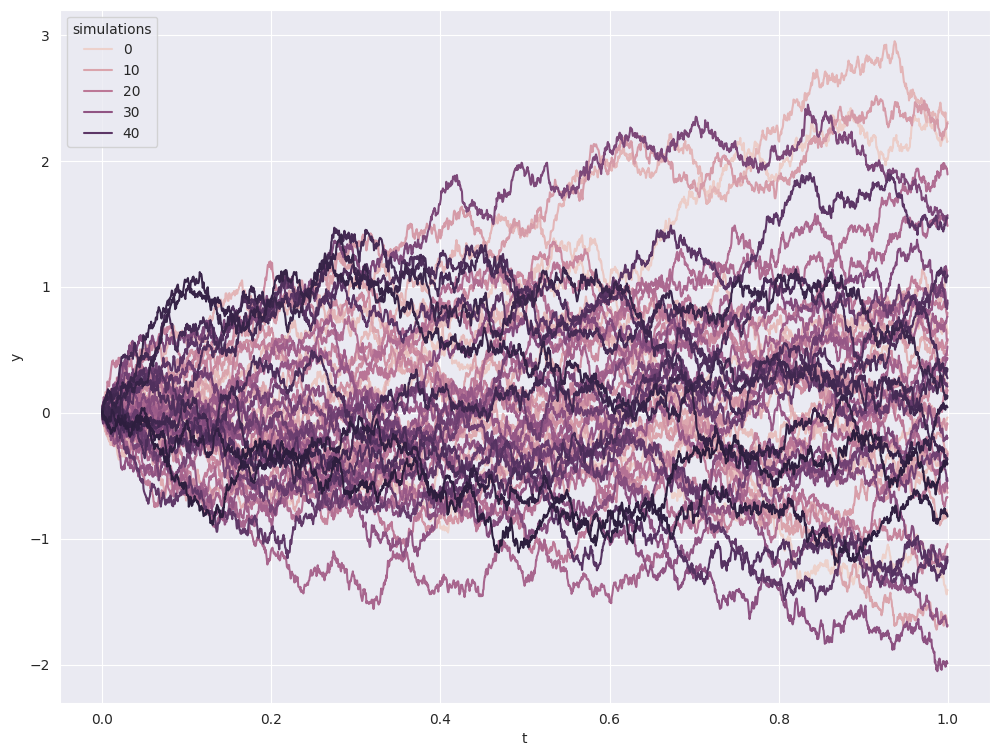

In [38]:
fig, ax=plt.subplots(figsize=(12, 9))

df_BH = pd.DataFrame(fbm)
df_BH["t"] = t_s
melt_df_BH = pd.melt(df_BH, "t", var_name="simulations", value_name="y")
sns.lineplot(melt_df_BH , x = "t", y = "y", hue ="simulations")
plt.savefig(f"latex/images/sample_trajectories_FBM_H_{H}.png")

## quantile line,

In [44]:
T = 1
n = 1000
H = 0.666
t_s = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 1000)

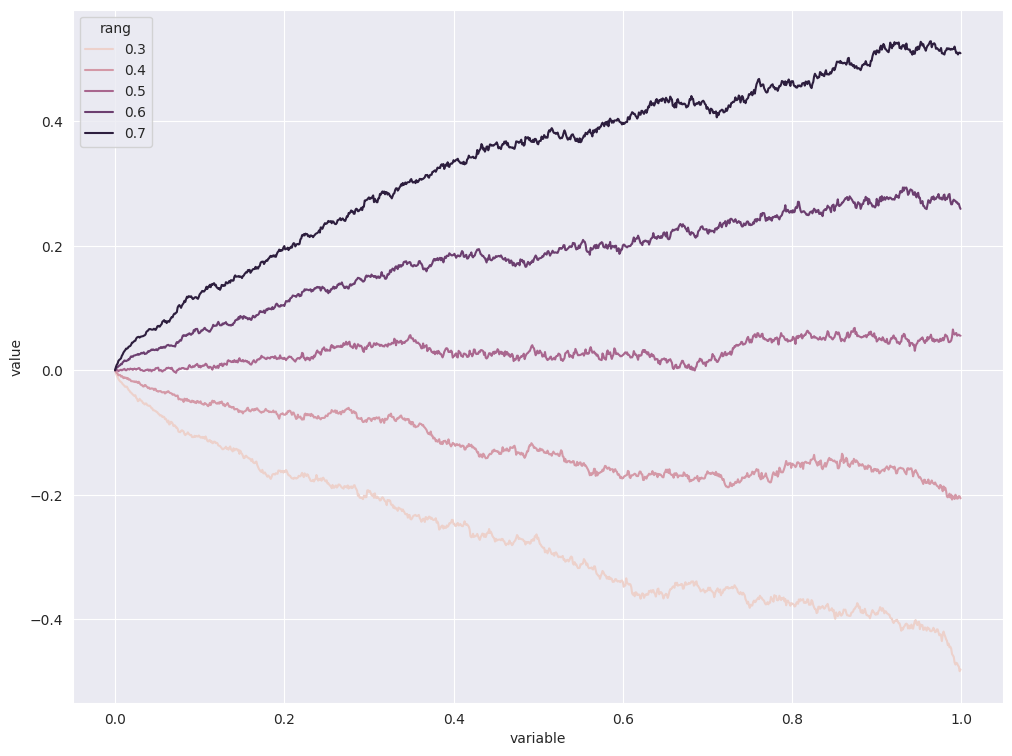

In [45]:
fig, ax=plt.subplots(figsize=(12, 9))
quantiles = np.arange(0.3, 0.8, 0.1)
quantiles_Df = get_quantils(pd.DataFrame(fbm), quantiles, t_s)
quantiles_Df["rang"] = quantiles_Df["rang"].round(2) 
sns.lineplot(quantiles_Df.melt("rang"), x="variable", y="value", hue="rang")
plt.savefig("latex/images/quantile_lines_FBM_H_{H}.png")

## Variancve in time

# FOU

### FOU

\begin{gather}
    Y(t) = \sigma \int_{-\infty}^{t} e^{-\lambda(t-x)}dB^H_x\\
    dY_t = -\lambda Y_t dt + \sigma dB^H_t
\end{gather}

In [196]:
def FOU(sigma, lambd, H, ts, trajectories = 1):
    n = len(ts)
    T = ts[-1]
    tsM = np.repeat(ts[:, None],  trajectories, 1)
    exp_lamd_t = np.exp(-lambd*tsM)
    fbm = cholesky_fbm(T, n+1, H, trajectories=trajectories)
    diff_fbm = np.diff(fbm, axis=0)
    O_u = sigma *exp_lamd_t * np.cumsum(np.exp(lambd*tsM)*diff_fbm, 0)  
    return O_u

In [199]:
T = 1
n = 1000
H = 1/2
sigma = 1
lambd = 2
trajectories = 1000

ts = np.linspace(0, T, n) 

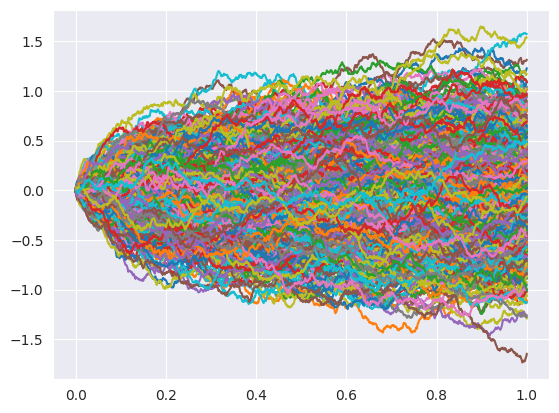

In [201]:
O_U = FOU(sigma, lambd, H, ts, trajectories = trajectories)
plt.plot(ts, O_U)
plt.show()

# $\alpha-stable$

In [175]:
def stable_random_variables_a(alpha):
    if alpha == 1:
        Omega = np.random.uniform(-pi/2, pi/2)
        return np.tan(Omega)
    else:
        Omega = np.random.uniform(-pi/2, pi/2)
        W = np.random.exponential(1)
        return np.sin(alpha*Omega)/np.cos(Omega)**(1/alpha)*(np.cos((alpha-1)*Omega)/W)**((1-alpha)/alpha)
    
def stable_random_variables_b(alpha, beta):
    Omega = np.random.uniform(-pi/2, pi/2)
    W = np.random.exponential(1)
    Delta_0 = np.arctan(beta*np.tan(pi*alpha/2))/alpha

    if alpha == 1:
        return 2/pi*((pi/2+beta*Omega)*np.tan(Omega)-beta*np.log(pi/2*W*np.cos(Omega)/(pi/2+beta*Omega)))
    else:
        a = np.sin(alpha*(Delta_0+Omega))/(np.cos(alpha*Delta_0)*np.cos(Omega))**(1/alpha)
        b = (np.cos(alpha*Delta_0+(alpha-1)*Omega)/W)**((1-alpha)/alpha)
        return a*b

def stable_random_variables_0(alpha, beta, gamma, delta):
    Z = stable_random_variables_a(alpha, beta)
    if alpha == 1:
        return gamma*Z+delta
    else:
        return gamma*(Z - beta*np.tan(pi*alpha/2)) + delta


def stable_random_variables_1(alpha, beta, gamma, delta):
    Z = stable_random_variables_b(alpha, beta)
    if alpha == 1:
        return gamma*Z + (delta + beta*2/pi*gamma*np.log(gamma))
    else:
        return gamma*Z+delta
    
def stable_random_variables(alpha, beta = 0, gamma=1, delta=0, stable_type = 1):
    if stable_type == 1:
        return stable_random_variables_1(alpha, beta, gamma, delta)
    elif stable_type ==0:
        return stable_random_variables_0(alpha, beta, gamma, delta)
    else:
        raise ValueError("Select bad stable_type!!!")
    
def  alpha_stable_process(alpha, beta, N, T=1, S_0 = 0):
    dt = T / N
    Z_t = [stable_random_variables(alpha, beta, gamma = dt**(1/alpha)) for _ in range(N)] 
    Z_t[0] = S_0
    return np.cumsum(Z_t)

In [688]:
def FAS(alpha, H, M, N, m, n):
    C =  (T /N) ** H
    mh = 1 / m
    d = H - 1 / alpha
    t0 = np.arange(mh, 1 + mh, mh)
    t1 = np.arange(1 + mh, M + mh, mh)
    A = mh**(1/alpha) * np.concatenate((t0**d, t1**d - (t1 - 1)**d))
    
    mh = 1 / m
    d = H - 1 / alpha
    t0 = np.arange(mh, 1 + mh, mh)
    t1 = np.arange(1 + mh, M + mh, mh)
    A = mh**(1/alpha) * np.concatenate((t0**d, t1**d - (t1 - 1)**d))

    C = C * (np.sum(np.abs(A)**alpha)**(-1/alpha))
    A = C * A

    Na = m * (M + N)
    A = np.fft.fft(A, Na)
    y= np.zeros((n, N))
    # y=[]
    for i in range(n):
        if alpha < 2:
            Z = np.array([stable_random_variables(alpha, 0) for _ in range(Na)])[None,:]
        elif alpha == 2:
            Z = np.random.randn(1, Na)

        Z = np.fft.fft(Z, Na)
        w = np.real(np.fft.ifft(Z * A, Na))
        y[i] = w[0][:N*m:m]
    return np.array(y)

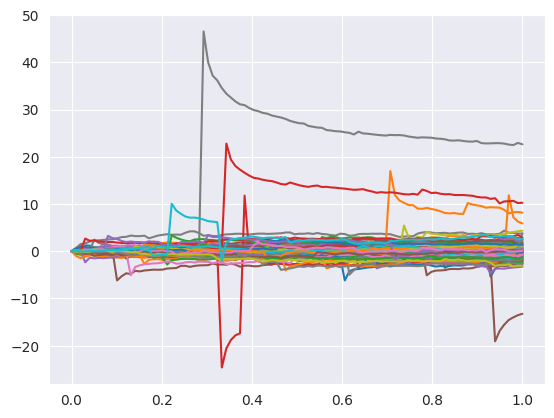

In [695]:
m =  100
M =  200
N = 100
n =  100
H =1/2
alpha =  1.5
# gamma =  (T /N) ** H
ts = np.linspace(0, 1, N)

y = FAS(alpha, H, M, N, m, n)
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
plt.plot(ts, FASM)
plt.show()

<Axes: xlabel='variable', ylabel='value'>

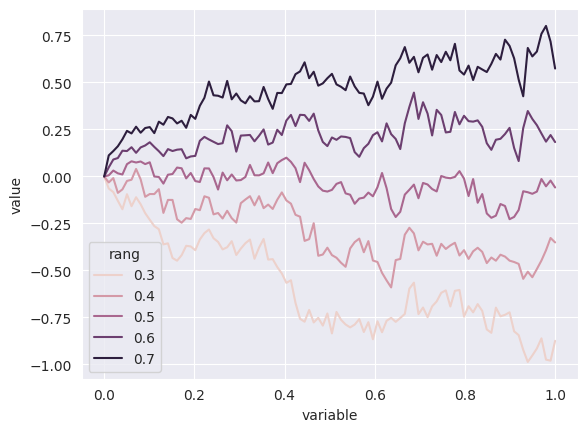

In [696]:
quantiles = np.arange(0.3, 0.8, 0.1)
quantiles_Df = get_quantils(pd.DataFrame(FASM), quantiles, ts)
quantiles_Df["rang"] = quantiles_Df["rang"].round(2) 
sns.lineplot(quantiles_Df.melt("rang"), x="variable", y="value", hue="rang")